
# Predicting the Quality Score of Wine Using Machine Learning
![wines-lined-up](./img/wine-tasting.jpg)
#### Sep 22, 2022
- [Luis Arce]( https://github.com/LuisVArce)
- [Tim Keriazes]( https://github.com/tim-keriazes)
- [Joshua Mayes]( https://github.com/MrEnigmamgine)


In [19]:
# DS Modules
import numpy as np
import pandas as pd

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# Helpers
import helpers
import wrangle
import model
import viz


---
## About this notebook:
This notebook presents a breif overview the key techniques, findings, and acheivements from the project and summarizes the results of our efforts.

### Project Description:
Our project examines 11 quantitative features of red/white wine data sets from the Vihno Verde region of Portugal. Using the physicochemical features/breakdown of the wine, we built a predictive machine learning model with a target variable of quality score. Our insights, discoveries, and modeling offer a distinct advantage to wine producers/stakeholders/distributors by using a wine's chemical composition and predicting its associated quality score.


### Notebook Outline:
<!-- 1. Intro
2. Executive Summary
3. Data Wrangling
4. Split
5. Exploration Highlights
    6. Stats Tests?
    8. Clusters
        7. Scale
9. Modeling
10. Conclusion
11. Next Steps -->




---
## About the data
Our project makes use of the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php), which is a labeled dataset consisting of 6500 observations.  Each observation represents a red or white Vihno Verde whine from the Portugal region and includes the physicochemical composition of the wine as well as a labeled `quality` score indicating wine expert's opinion of the wine on a scale of 1 to 10.


### Target variable
**`quality`** - Quality score is the median score given to associated wine based off the rankings of three industry experts

<div style="background-color: #f26200; color: white; border-radius: 25px; padding: 15px; width: 55%">
 <strong>Caution!</strong> <br>
  Models trained on biased data will reflect the bias of the humans that labeled it.  <br>
  Because this data was created by a small group, there is a high risk of bias.
</div>

### Data Dictionary
| **Variable Name** | **Explanation** | **Unit** | **Values** |
| :---: | :---: | :---: | :---: |
| Fixed Acidity |  Acids that do not evaporate readily (Tartaric Acid) | g/L | Float |
| Volatile Acidity | Acids evaporate readily (Acetic acid) | g/L | Float |
| Citric Acid | level of Citric acid | g/L | Float |
| Residual Sugar | Sugar that remains after fermenation | g/L | Float |
| Chlorides | Sodium Chloride content | g/L | Float |
| Free Sulfur Dioxide | Levels of free, gaseous sulfur dioxide | mg/L | Float |
| Total Sulfur Dioxide | Total Level of Sulfur Dioxide | mg/L | Float |
| Density | Density in relation to water | g/cm^3 | Float |
| pH| Acidity of the wine | 1-14 | Float |
| Sulphates | Level of potassium sulfate | g/L | Float |
| Alcohol | Alcohol by Volume per wine | ABV% | Float |
| Quality |  The median value of at least 3 independent evualations by wine experts| 1-10 | Integer |



## Data Challenges and preparation
The dataset used was a very clean dataset.  There were zero null values and none of the values could be identified as obviously erroneous.  However, we discovered 1,177 duplicate records which we dropped leaving us with 5320 observations remaining after cleaning, 1359 of which are red wines and 3961 of which are white wines.  `[Outliers] [Legal Limits]`


## Feature Engineering

#### pH
`paragraph`

#### Flavor Profiles
During our research on the variables included in this dataset we found that some variables are considered to have more profound impacts on flavor than others.  By running a K-means clustering model on the most impactful variables, we found 4 disctinct "flavor profiles" that describe the flavor of a wine and highlight the prefences of the wine testers.

#### Bound Sulfur Dioxide
Bound sulfur dioxide is calculated by subtracting the free sulfur dioxide from the total sulfur dioxide.  Free sulfur dioxide describes the amount of sulfur dioxide that is available for bonding, therefore the difference can be inferred as the amount of sulfur dioxide that is already bound and no longer available for bonding.

Because total sulfur dioxide contains the value from free sulfur dioxide there is some multicolinearity introduced by the two variables.  To compensate for that multicolinearity this feature should be calculated and the total sulfur dioxide column should be dropped before modeling.

### Engineered Feature Dictionary

| **Variable Name** | **Explanation** | **Unit** | **Values** |
| :---: | :---: | :---: | :---: |
| Bound Sulfur Dioxide | Difference of free sulfur dioxide and total sulfur dioxide | mg/L | float |
| Flavor Profile | K-means cluster using volatile acidity, chlorides, residual sugar, and alcohol | 0-3 | category |

In [3]:
# Load the data into the notebook
train, validate, test = wrangle.wrangle_data_and_split('both')


---
# Exploration Summary
<!-- I feel like something should be said here. -->


## Key Findings
### Regardless of color, a wine with an ABV above 12% is much more likely to be of high quality.


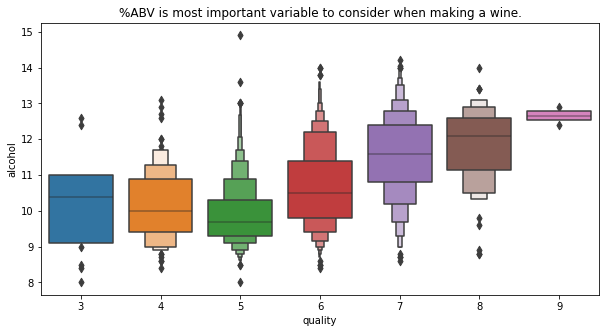

In [4]:
# Draw ABV boxen plot
viz.abv_boxen_by_quality(train)

The the chart above we can see the distribution of Alcohol by Volume (ABV) for each quality.  For each quality score we can find wines as with a low ABV between 8% and 9% as well as a high ABV between 14.5% and 13%.  We can infer that ABV is a great predictor for good wines because the most dense regeions for each category show an upward trend.  

However, the distributions for qualities 3 and 4 tell us a different story.  Because the distributions are quite similar, and in-fact have a higher mean than quality 5 wines, we can infer that there is something else going on that causes a wine to be considered a bad wine.

### Red and white wines are different worlds.

<div style="background-color: #f26200; color: white; border-radius: 25px; padding: 15px; width: 55%">
 <strong>Caution!</strong> <br>
  A model only performs well for the world in which it was trained.
</div>

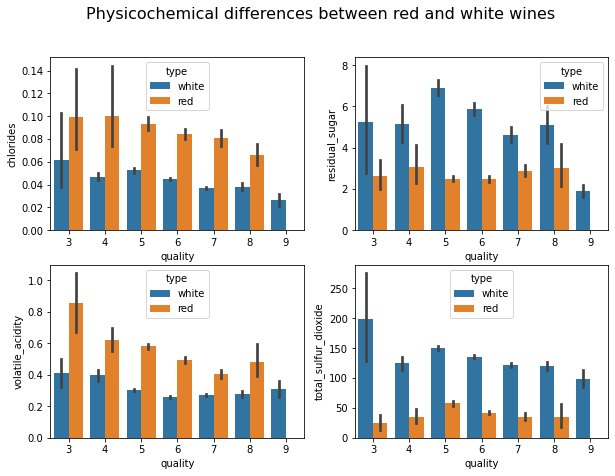

In [18]:
# Draw plots to show differences between red and white wines.
fig, ax = plt.subplots(2,2,figsize=[10,7])
fig.suptitle('Physicochemical differences between red and white wines', fontsize=16)
sns.barplot(data=train, x='quality', y='chlorides', hue='type', ax=ax[0][0])
sns.barplot(data=train, x='quality', y='residual_sugar', hue='type', ax=ax[0][1])
sns.barplot(data=train, x='quality', y='volatile_acidity', hue='type', ax=ax[1][0])
sns.barplot(data=train, x='quality', y='total_sulfur_dioxide', hue='type', ax=ax[1][1])
plt.show()

The figure above demonstrates some of the noticeable differences between the types of wines.  It might come as no surprise to learn that red wines and white wines are different types of wines, but this distinction becomes very important when applying machine learning models.  A model is only good in the world it was trained in.  Because of this we have decided that exploring and modeling should be done on each wine type separately.

### Flavor Profiles

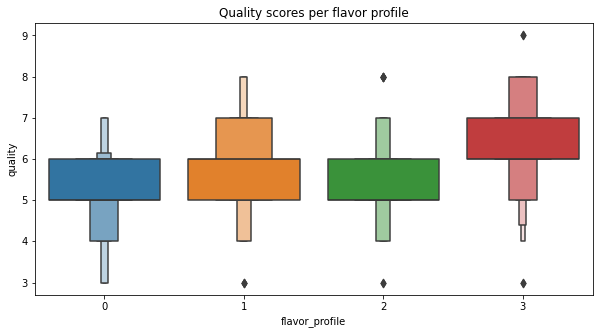

In [32]:
# Demonstrate flavor profiles
# Create the profiler instance
profiler = model.FlavorProfile()
# Fit it to the training data
profiler.fit(train)
# Assign clusters to the data
train['flavor_profile'] = profiler.predict(train)
# Draw the plot
plt.figure(figsize=[10,5])
sns.boxenplot(data=train, x='flavor_profile', y='quality')
plt.title('Quality scores per flavor profile')
plt.show()

By creating these clusters we discovered that the testers for this dataset hat a clear preference for strong, unsweetened wines.  In addition to being a strong predictor for quality, these clusters can help manufacturers market their wine to the appropriate customers.  For example, people who only drink socially might prefer sweeter wines with a low alcohol strength.

![flavor_profile visualization](./img/plotly_flavor_profiles.png)

## Red Wines

### Most predictive qualities